In [1]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp
from pylab import *
from scipy.optimize import curve_fit
from matplotlib.backends.backend_pdf import PdfPages
from notebook_adlib_3 import *

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
#matplotlib.style.use('ggplot')

In [2]:
def gamma_f(x, k, theta, A):
    return A*(1/(theta**k))*(x**(k - 1))*np.exp(-x/theta)/sp.special.gamma(k)

def bimodal(x, k1, theta1, A1, k2, theta2, A2):
    return gamma_f(x, k1, theta1, A1) + gamma_f(x, k2, theta2, A2)

def bimodal_construct(k1, theta1, A1):
    def bimodal(x, k2, theta2, A2, A1):
        return gamma_f(x, k1, theta1, A1) + gamma_f(x, k2, theta2, A2)
    return bimodal

def gamma_dists(permut_filename, data_filename):
    data0 = []
    minval = 1
    maxval = 0
    for i in open(permut_filename):
        if eval(i) > 1000:
            continue
        val = np.log10(eval(i) + 1)
        data0.append(val)
    data0 = np.array(data0)
    
    with PdfPages("dists" + '.pdf') as pdf:
        y0,x0,_ = hist(data0, 20, alpha=.3, label='data')
    
        x0=(x0[1:]+x0[:-1])/2 # for len(x)==len(y)
    
        expected0 = (1,1,1)
        params0,cov = curve_fit(gamma_f,x0,y0,expected0)
    
        data1 = []
        for i in open(data_filename):
            if eval(i) > 1000:
                continue
            val = np.log10(eval(i) + 1)
            data1.append(val)
            if val > maxval:
                maxval = val
            if val < minval:
                minval = val
        data1 = np.array(data1)
        
        y1,x1,_ = hist(data1, 20, alpha=.3, label='data')
        
        x1=(x1[1:]+x1[:-1])/2 # for len(x)==len(y)
        bimodal_func = bimodal_construct(*params0)
        
        expected1 = (1,1,1,1)
        params1, cov = curve_fit(bimodal_func,x1,y1,expected1)
        
        sigma=sqrt(diag(cov))
        xmax = max(x0)
        x_step = 0.01
        xran = [0]
        for i in range(int(xmax/x_step + 1)):
            xran.append(xran[-1] + 0.01)
        xran = np.array(xran)
        plot(xran,gamma_f(xran,*params0),color='red',lw=3,label='model')
        
        params0_dist = np.append(params0[:-1], params1[-1])
        params1_dist = params1[:-1]
#FITTED CURVES
        plot(xran,gamma_f(xran,*params0_dist),color='blue',lw=3,label='model')
        plot(xran,gamma_f(xran,*params1_dist),color='blue',lw=3,label='model')
        pdf.savefig()
        params_dict = {"0dist":{'A':params0_dist[2], 
                                'k':params0_dist[0], 
                                "theta":params0_dist[1]}, 
                       "real_dist":{'A':params1_dist[2], 
                                    'k':params1_dist[0], 
                                    "theta":params1_dist[1]}}
    return params_dict, minval, maxval

In [3]:
class Fit_model():
    def __init__(self, gammadist_param_dict, a_IN, a_NI, p_bI, p_bN):
        self.A0 = gammadist_param_dict["0dist"]['A']
        self.k0 = gammadist_param_dict["0dist"]['k']
        self.theta0 = gammadist_param_dict["0dist"]['theta']
        self.A1 = gammadist_param_dict["real_dist"]['A']
        self.k1 = gammadist_param_dict["real_dist"]['k']
        self.theta1 = gammadist_param_dict["real_dist"]['theta']
        self.a_IN = a_IN
        self.a_NI = a_NI
        self.p_bI = p_bI
        self.p_bN = p_bN

def run_viterbi(inp_list, fit_model):
    probs = [[np.log10(fit_model.p_bI)],[np.log10(fit_model.p_bN)]]
    paths = [['b'],['b']]
    p_II = np.log10(1 - fit_model.a_IN)
    p_IN = np.log10(fit_model.a_IN)
    p_NI = np.log10(fit_model.a_NI)
    p_NN = np.log10(1 - fit_model.a_NI)
    
    for i in inp_list:
        dist_I_value = gamma_f(i, fit_model.k1, fit_model.theta1, fit_model.A1)
        dist_N_value = gamma_f(i, fit_model.k0, fit_model.theta0, fit_model.A0)
        p_e_I = np.log10(dist_I_value/(dist_I_value + dist_N_value))
        p_e_N = np.log10(dist_N_value/(dist_I_value + dist_N_value))
        
        b_II = probs[0][-1] + p_II + p_e_I
        b_IN = probs[0][-1] + p_IN + p_e_N
        b_NI = probs[1][-1] + p_NI + p_e_I
        b_NN = probs[1][-1] + p_NN + p_e_N
        
        if b_II >= b_NI:
            probs[0].append(b_II)
            paths[0].append(0)
        else:
            probs[0].append(b_NI)
            paths[0].append(1)
        
        if b_NN >= b_IN:
            probs[1].append(b_NN)
            paths[1].append(1)
        else:
            probs[1].append(b_IN)
            paths[1].append(0)
    
    states = []
    if probs[0][-1] > probs[1][-1]:
        states.append(0)
        index = 0
    else:
        states.append(1)
        index = 1
    
    for i in list(range(len(paths[0]) - 1, 0, -1)):
        states.append(paths[index][i])
        index = paths[index][i]
    
    states = states[::-1]
    
    return states, paths, probs
           
        
def run_viterbi_for_all(disord_reg_site_dict, fit_model):
    p_isls = dict()
    vit_dr_site_dict = dict()
    for gene_id in disord_reg_site_dict.keys():
        vit_dr_site_dict[gene_id] = dict()
        p_isls[gene_id] = dict()
        for disord_reg in disord_reg_site_dict[gene_id].keys():
            if len(disord_reg_site_dict[gene_id][disord_reg]) > 1:
                vit_dr_site_dict[gene_id][disord_reg] = []
                crd_list = disord_reg_site_dict[gene_id][disord_reg]
                inp_list = [np.log10(crd_list[i] - crd_list[i-1] + 1) for i in range(1, len(crd_list))]
                states, paths, probs = run_viterbi(inp_list, fit_model)
                l = len(states)
                for i in range(1, l):
                    if states[i] == 0:
                        states[i-1] = 0
                if states[1] == 1:
                    states[0] = 1
#                print(states)
                for i in range(l):
                    if states[i] == 0:
                        vit_dr_site_dict[gene_id][disord_reg].append(disord_reg_site_dict[gene_id][disord_reg][i])
                
                isl_crds = [[]]
                for i in range(l):
                    if states[i] == 0:
                        crd = disord_reg_site_dict[gene_id][disord_reg][i]
                        isl_crds[-1].append(crd)
                    else:
                        if isl_crds[-1] != []:
                            isl_crds.append([])
                p_isls[gene_id][(disord_reg[0], disord_reg[1])] = isl_crds
                        
    return vit_dr_site_dict, p_isls

In [4]:
#psite_filename = "psite_islands/d_human_hmr_cons_all.tsv"
#disord_reg_filename = "psite_islands/human_proteome_disordered_regs.txt"
#stat_filename = "psite_islands/d_human_hmr_cons_S2_stats.txt"
#permut_filename = "psite_islands/d_human_hmr_cons_S2_permuts.txt"
#in_island_psites = "psite_islands/d_human_hmr_cons_isl.tsv"
#no_isl_psites = "psite_islands/d_human_hmr_cons_n_isl.tsv"
#psite_isl_file = "psite_islands/d_human_hmr_cons_psite_isls.tsv"
#
psite_filename = "psite_islands/d_human_iptmnet.tsv"
disord_reg_filename = "psite_islands/human_proteome_disordered_regs.txt"
stat_filename = "psite_islands/d_human_iptmnet_S2_stats.txt"
permut_filename = "psite_islands/d_human_iptmnet_S2_permuts.txt"
in_island_psites = "psite_islands/d_human_iptmnet_isl.tsv"
no_isl_psites = "psite_islands/d_human_iptmnet_n_isl.tsv"
psite_isl_file = "psite_islands/d_human_iptmnet_psite_isls.tsv"
#
#psite_filename = "psite_islands/d_mouse_iptmnet.tsv"
#disord_reg_filename = "psite_islands/mouse_proteome_disordered_regs.txt"
#stat_filename = "psite_islands/d_mouseS2_stats.txt"
#permut_filename = "psite_islands/d_mouseS2_permuts.txt"
#in_island_psites = "psite_islands/d_mouse_iptmnet_isl.tsv"
#no_isl_psites = "psite_islands/d_mouse_iptmnet_n_isl.tsv"
#psite_isl_file = "psite_islands/d_mouse_iptmnet_psite_isls.tsv"
#
#psite_filename = "psite_islands/d_human_iptmnet_subsamp_02.tsv"
#disord_reg_filename = "psite_islands/human_proteome_disordered_regs.txt"
#stat_filename = "psite_islands/d_human_iptmnet_subsamp_02_S2_stats.txt"
#permut_filename = "psite_islands/d_human_iptmnet_subsamp_02_S2_permuts.txt"
#in_island_psites = "psite_islands/d_human_iptmnet_subsamp_02_isl.tsv"
#no_isl_psites = "psite_islands/d_human_iptmnet_subsamp_02_n_isl.tsv"
#psite_isl_file = "psite_islands/d_human_iptmnet_subsamp_02_psite_isls.tsv"
#
#psite_filename = "psite_islands/d_mouse_iptm_col.tsv"
#disord_reg_filename = "psite_islands/mouse_proteome_disordered_regs.txt"
#stat_filename = "psite_islands/d_mouse_iptm_colS2_stats.txt"
#permut_filename = "psite_islands/d_mouse_iptm_colS2_permuts.txt"
#in_island_psites = "psite_islands/d_mouse_iptm_isl.tsv"
#no_isl_psites = "psite_islands/d_mouse_iptm_n_isl.tsv"
#psite_isl_file = "psite_islands/d_mouse_iptm_psite_isls.tsv"

#psite_filename = "psite_islands/d_mouse_iptmnet_n_isl.tsv"
#disord_reg_filename = "psite_islands/mouse_proteome_disordered_regs.txt"
#stat_filename = "psite_islands/mouse_indS2_stats.txt"
#permut_filename = "psite_islands/mouse_indS2_permuts.txt"
#in_island_psites = "psite_islands/tmp1.tsv"
#no_isl_psites = "psite_islands/tmp2.tsv"
#psite_isl_file = "psite_islands/tmp3.tsv"

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


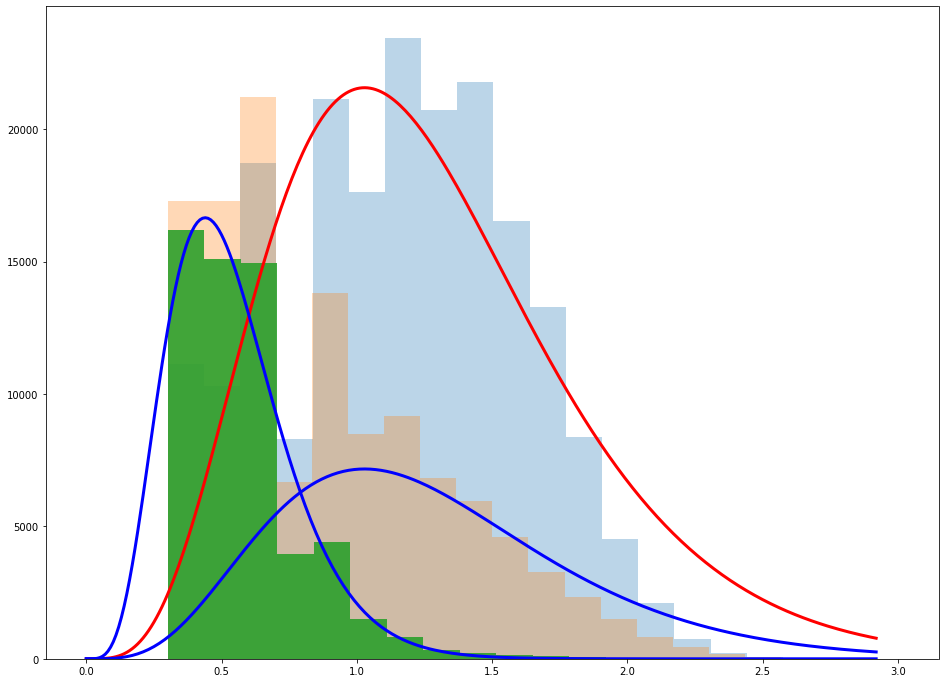

In [5]:
nbins = 20

gammadist_param_dict, minval, maxval = gamma_dists(permut_filename, stat_filename)
psite_dict = make_psite_dict(psite_filename)
disord_reg_dict = make_disord_reg_dict1(disord_reg_filename)
disord_reg_site_dict = make_disord_reg_site_dict(disord_reg_dict, psite_dict)

A_I = float(gammadist_param_dict["real_dist"]['A'])
A_N = float(gammadist_param_dict["0dist"]['A'])
p_bI = A_I/(A_I + A_N)
p_bN = A_N/(A_I + A_N)
fit_model = Fit_model(gammadist_param_dict, 0.2, 0.2, p_bI, p_bN)
vit_dr_site_dict, p_isls = run_viterbi_for_all(disord_reg_site_dict, fit_model)
#distance_dist = make_distance_distribution(vit_dr_site_dict, nbins, minval, maxval)
#compare_dists(fit_model, distance_dist, plot=True)

count = 0
for k in vit_dr_site_dict.keys():
    for k2 in vit_dr_site_dict[k].keys():
        if vit_dr_site_dict[k][k2]:
            count += len(vit_dr_site_dict[k][k2])
#            if len(vit_dr_site_dict[k][k2]) % 2 == 1:
#                print(k, k2, vit_dr_site_dict[k][k2])
#print(count)

with open(psite_filename) as infile, open(in_island_psites, 'w') as outfile:
    for s in infile:
        filestr = s.strip().split()
        if not vit_dr_site_dict.get(filestr[0]):
            continue
        for disord_reg in vit_dr_site_dict[filestr[0]].keys():
            k = eval(filestr[2]) - 1
            if k in vit_dr_site_dict[filestr[0]][disord_reg]:
                outfile.write(s)
#                print(s.strip())

psite_dict_isl = make_psite_dict(in_island_psites)
#print(psite_dict_isl) 

with open(no_isl_psites, 'w') as no_isl, open(psite_filename) as infile:
    for s in infile:
        rec = s.strip().split()
        if not psite_dict_isl.get(rec[0]):
            no_isl.write(s)
        elif eval(rec[2]) - 1 not in psite_dict_isl[rec[0]]:
            no_isl.write(s)

arr = []
with open(psite_isl_file, 'w') as pi_file:
    for gene_id in p_isls.keys():
        for crd_pair in p_isls[gene_id].keys():
            for isl_arr in p_isls[gene_id][crd_pair]:
                isl_arr_str = '\t'.join(list(map(str, isl_arr)))
                pi_file.write(gene_id + '\t' + isl_arr_str + '\n')
                for i in range(1, len(isl_arr)):
                    arr.append(isl_arr[i] - isl_arr[i - 1])
arr.append(1000)
#print(p_isls)
with PdfPages("dists_test" + '.pdf') as pdf:
    y0,x0,_ = hist(log10(np.array(arr) + 1), 20, alpha=0.9, label='data')
    pdf.savefig()

[0.9990985576923077, 0.0, 0.0, 0.0, 0.0]
[0.6932351502664003, 0.102517707986458, 0.06806008661477411, 0.03377189217032967, 0.10301612450049949]
[0.49954927884615385, 0.16059445112179488, 0.14490685096153844, 0.04472155448717948, 0.14932642227564102]
[0.4130500575813076, 0.19674119283494282, 0.15569337346681095, 0.05538569503413253, 0.17973064262126762]
[0.23465648399130679, 0.2267953025988463, 0.20798996298484995, 0.059043518497394705, 0.2721156934660638]


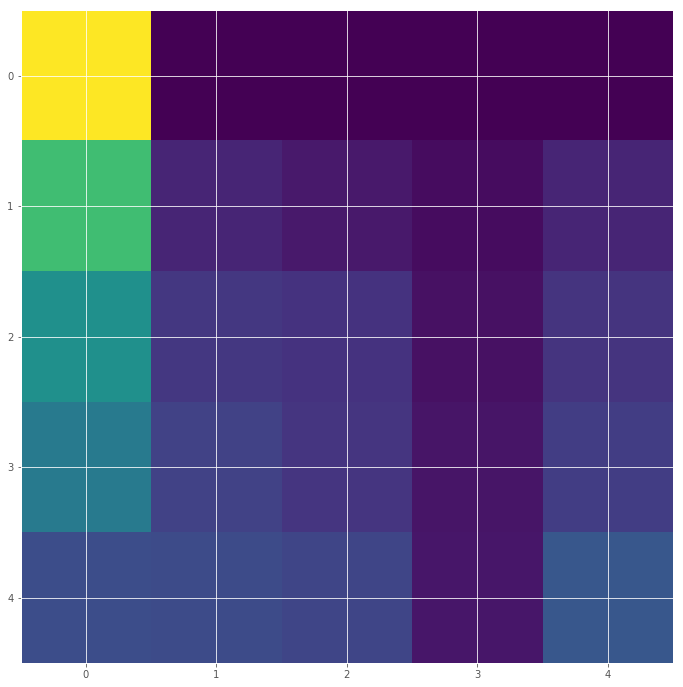

[0.030615040230424842, 0.902593551914819, 0.030517496580844995, 0.007768228922075075, 0.027848220155912467]
[0.1583864260146311, 0.5230334896814527, 0.15242678575841875, 0.0435411162728717, 0.12195472007670198]
[0.1757674305751229, 0.4962161137374813, 0.16984113939242143, 0.02634805839934045, 0.13281345118951954]
[0.20318405440407097, 0.3404744667151615, 0.1932966619432707, 0.04695002291156137, 0.21543733183001168]
[0.21538156215177912, 0.2096468996227871, 0.2330252236008982, 0.04761020100314101, 0.2953223069152802]


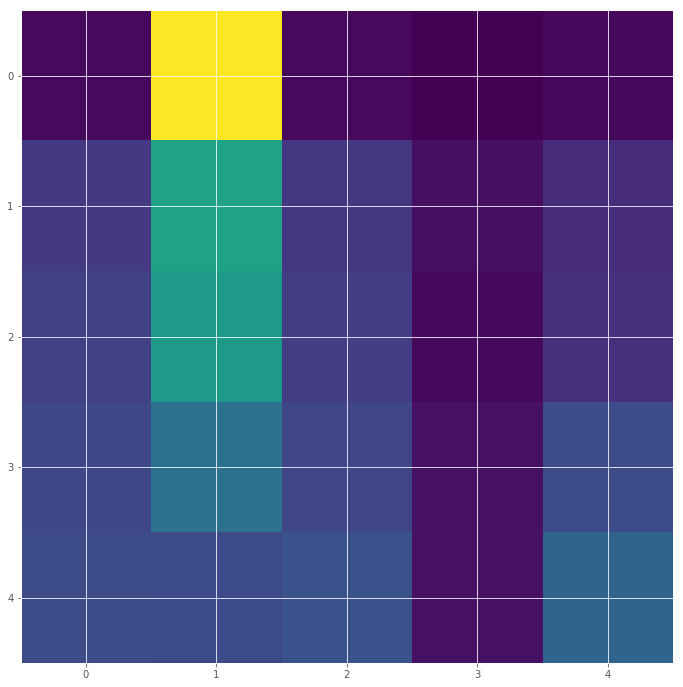

[0.01430727080551847, 0.022599728381803755, 0.9160325819505903, 0.003859312416555407, 0.04203288214646657]
[0.10450343967429246, 0.12092488735304156, 0.5411110096419676, 0.027466019507491467, 0.20628669989797324]
[0.1143156152647975, 0.1377166082554517, 0.5001460280373832, 0.03541179906542056, 0.21270200545171336]
[0.13627578295329182, 0.17562194537930328, 0.3872106836470107, 0.032993281624268775, 0.26819036247089173]
[0.1886858051249114, 0.20043383882087767, 0.24648517342368825, 0.05316930822445527, 0.31151793048083376]


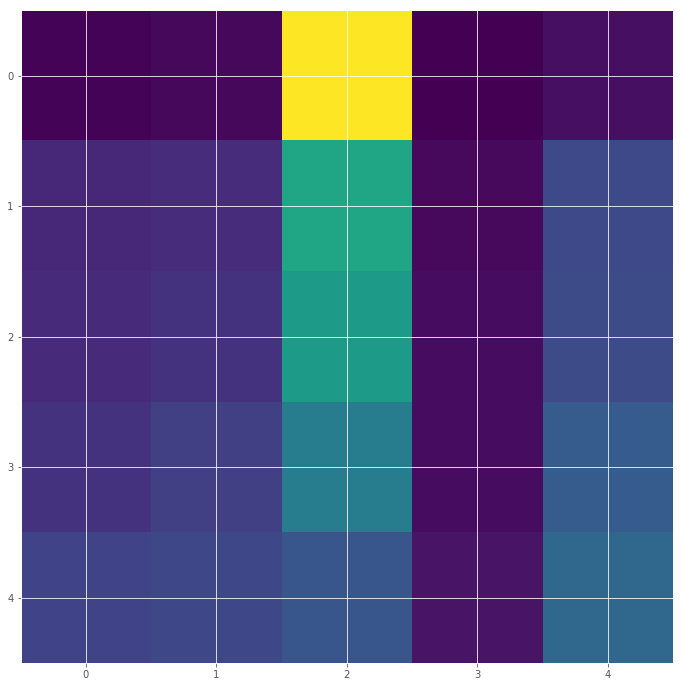

[0.07281056639695382, 0.06500475963826749, 0.06535776614310645, 0.7118435665556084, 0.08498334126606377]
[0.11474694589877835, 0.1094022687609075, 0.11594677137870854, 0.5, 0.15990401396160558]
[0.20525260080233895, 0.1332902699394846, 0.12099718199194638, 0.3934113007411438, 0.1470486465250863]
[0.24171029668411873, 0.1397730105845289, 0.14267129031526937, 0.2852791187869722, 0.1905662836291109]
[0.19651553362286348, 0.2009552684252407, 0.1938665195633166, 0.16504822171976466, 0.24361445666881454]


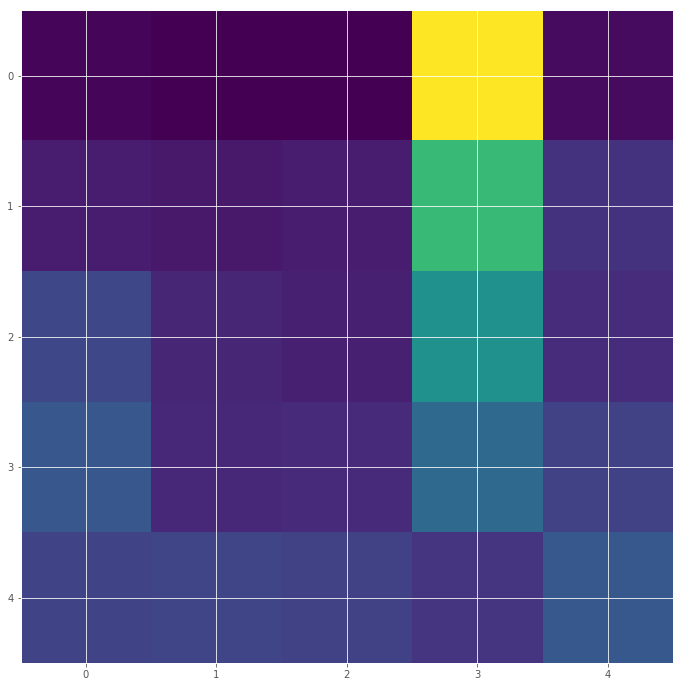

[0.03649396689169416, 0.05009371244982225, 0.08134551235200585, 0.009401763460205019, 0.8217795666880673]
[0.11492750575542783, 0.11439325195488817, 0.218949998607006, 0.044527224960762016, 0.5077923374940528]
[0.1271589120246145, 0.11190677435512146, 0.22517866087080965, 0.03564832206361132, 0.4992218525276376]
[0.17834031212130386, 0.16506702663727457, 0.26409138709906127, 0.0439096232706032, 0.3491819696438941]
[0.23819640126422603, 0.20938015458458875, 0.25170783149563325, 0.0647259629882121, 0.2365799684394768]


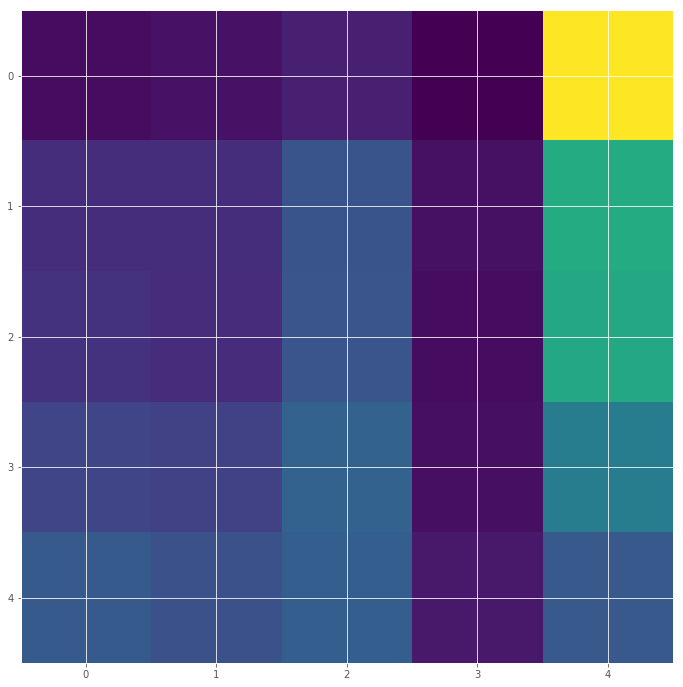

In [79]:
#### PHOSPHOSITE CONTEXT HEATMAPS ####

def dictsum(_dict):
    _sum = 0
    for k in _dict.keys():
        _sum += _dict[k]
    return _sum

def transpose(m):
    return [[m[j][i] for j in range(len(m))] for i in range(len(m[0]))]

def heatmap_reduce(hm, rownum):
    heatmap = []
    l = len(hm)
    for i in range(rownum):
        hm_part = hm[int(i*(l/rownum)):int((i+1)*(l/rownum))]
        hm_part_t = transpose(hm_part)
#        print(hm_part)
        mean_vals = []
        for j in range(5):
            mean_val = float(sum(hm_part_t[j])*rownum)/l
            mean_vals.append(mean_val)
        print(mean_vals)
        heatmap.append(mean_vals)
    return heatmap

def heatmap_sort(hm, colnum):
    heatmap = []
    for i in hm:
        if i[colnum] != 0:
            heatmap.append(i)
    for i in range(len(heatmap)):
        for j in range(i, len(heatmap)):
            if heatmap[i][colnum] < heatmap[j][colnum]:
                temp = heatmap[i]
                heatmap[i] = heatmap[j]
                heatmap[j] = temp
    return heatmap

def make_motif_heatmap(psite_isl_dict, motif_dict, outfile_name, colnum):
    heatmap = []
    motifs = {'A':0, 'B': 1, 'P': 2, 'Y': 3, 'O': 4}
    for uniprot_id in psite_isl_dict.keys():
        for isl in psite_isl_dict[uniprot_id]:
            motif_numdict = {'A':0, 'B': 0, 'P': 0, 'Y': 0, 'O': 0}
            for crd in isl:
                motif = motif_dict[uniprot_id][crd + 1]
                motif_numdict[motif] += 1
            s = dictsum(motif_numdict)
            heatmap_line = []
            for motif in "ABPYO":
                heatmap_line.append(float(motif_numdict[motif])/s)
            heatmap.append(heatmap_line)
    heatmap = heatmap_sort(heatmap, colnum)
    heatmap = heatmap_reduce(heatmap, 5)
    with open(outfile_name, 'w') as outhandle:
        for s in heatmap:
#            print(s)
            outhandle.write('\t'.join(list(map(str, s))) + '\n')
    hm = np.array(heatmap[:5])
    plt.imshow(hm)
    plt.show()


def clean_psite_isls(psite_isl_file_in, psite_isl_file_out):
    inhandle = open(psite_isl_file_in)
    outhandle = open(psite_isl_file_out, 'w')
    for s in inhandle:
        s = s.strip().split()
        if len(s) < 2:
            continue
        gene_name = s[0]
        crd_list = list(map(eval, s[1:]))
        isl_crds = [crd_list[0]]
        for i in range(1, len(crd_list)):
            if (crd_list[i] - crd_list[i - 1]) < 10:
                isl_crds.append(crd_list[i])
            else:
                if len(isl_crds) > 1:
                    outhandle.write(gene_name + '\t' + '\t'.join(list(map(str, isl_crds))) + '\n')
                isl_crds = []
        if len(isl_crds) > 1:
            outhandle.write(gene_name + '\t' + '\t'.join(list(map(str, isl_crds))) + '\n')
        isl_crds = []
    inhandle.close()
    outhandle.close()

clean_psite_isls("psite_islands/d_human_hmr_cons_psite_isls.tsv", "psite_islands/d_human_hmr_cons_psite_isls_2.tsv")  
psite_motif_file = "human_iptmnet_motifs.tsv"
psite_isl_dict = make_psite_isl_dict("psite_islands/d_human_hmr_cons_psite_isls_2.tsv")
motif_dict = make_motif_dict(psite_motif_file)

make_motif_heatmap(psite_isl_dict, motif_dict, "tmp.txt", 0) 
make_motif_heatmap(psite_isl_dict, motif_dict, "tmp.txt", 1)
make_motif_heatmap(psite_isl_dict, motif_dict, "tmp.txt", 2)
make_motif_heatmap(psite_isl_dict, motif_dict, "tmp.txt", 3)
make_motif_heatmap(psite_isl_dict, motif_dict, "tmp.txt", 4) 

In [101]:
# HMR conservative
hmr_isl = 26484
hmr_nis = 16999

# Human
human_isl = 74617
human_nis = 82681

# Human 40%
human_40_isl = 23730
human_40_nis = 39212

# Mouse
mouse_isl = 38159
mouse_nis = 30558

# HMR conservative
hmr_S_isl = 20376
hmr_S_nis = 13338
hmr_T_isl = 4613
hmr_T_nis = 2406
hmr_Y_isl = 1494
hmr_Y_nis = 1253

# Human
human_S_isl = 51211
human_S_nis = 55875
human_T_isl = 17438
human_T_nis = 18767
human_Y_isl = 5967
human_Y_nis = 8031

# Mouse
mouse_S_isl = 28635
mouse_S_nis = 23256
mouse_T_isl = 7658
mouse_T_nis = 5416
mouse_Y_isl = 1866
mouse_Y_nis = 1984

print(st.chi2_contingency([[hmr_S_isl, hmr_isl],[hmr_S_nis, hmr_nis]])[1])
print(st.chi2_contingency([[hmr_T_isl, hmr_isl],[hmr_T_nis, hmr_nis]])[1])
print(st.chi2_contingency([[hmr_Y_isl, hmr_isl],[hmr_Y_nis, hmr_nis]])[1])
print('\n')
print(st.chi2_contingency([[human_S_isl, human_isl],[human_S_nis, human_nis]])[1])
print(st.chi2_contingency([[human_T_isl, human_isl],[human_T_nis, human_nis]])[1])
print(st.chi2_contingency([[human_Y_isl, human_isl],[human_Y_nis, human_nis]])[1])
print('\n')
print(st.chi2_contingency([[mouse_S_isl, mouse_isl],[mouse_S_nis, mouse_nis]])[1])
print(st.chi2_contingency([[mouse_T_isl, mouse_isl],[mouse_T_nis, mouse_nis]])[1])
print(st.chi2_contingency([[mouse_Y_isl, mouse_isl],[mouse_Y_nis, mouse_nis]])[1])

0.188451885904
1.56291741425e-14
1.38071577532e-11


0.0517883349848
0.0126091703261
9.74972852865e-28


0.231401678849
1.39133735678e-10
1.14360677083e-17


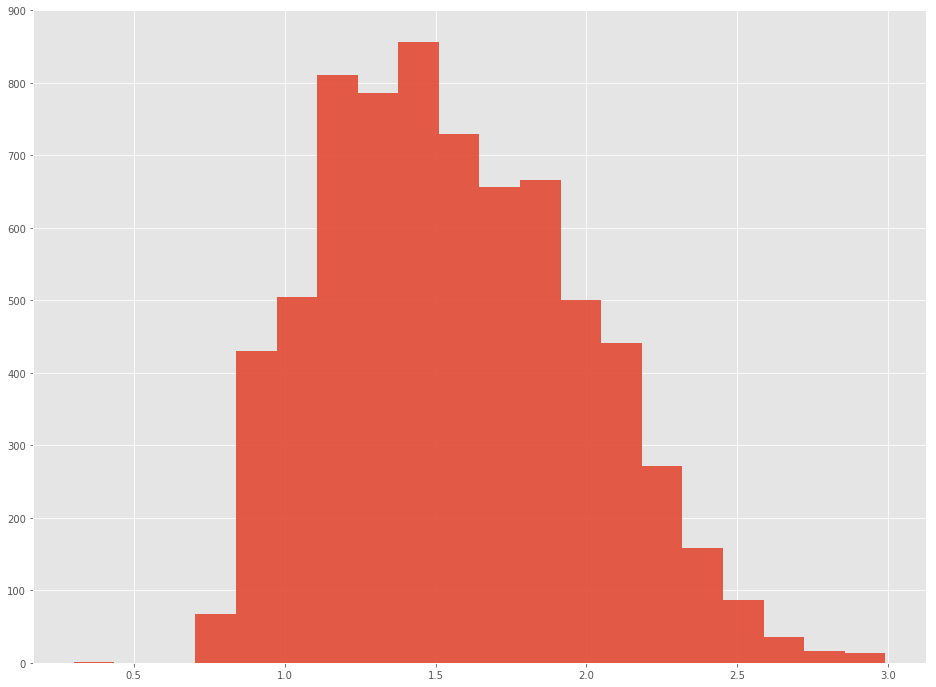

In [84]:
data0 = []

for i in open("psite_islands/d_human_hmr_consS2_stats.txt"):
    if eval(i) > 1000:
        continue
    val = np.log10(eval(i) + 1)
    data0.append(val)
data0.append(np.log10(2))
data0 = np.array(data0)

with PdfPages("dist_non_isl_S2" + '.pdf') as pdf:
    y0,x0,_ = hist(data0, 20, alpha=0.9, label='data')
    pdf.savefig()